* kmeans
* affinity p
* hdbscan

Is there a way of identify significant change here? 
Both static embeddings and centroid BERTs are "means" over several usages.
I tested model it by a chi-square test below. Problematic for the familje data due to 0 expected frequencies. 


In [38]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.special import rel_entr
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from scipy.stats.contingency import expected_freq
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import time

from sklearn.feature_extraction.text import CountVectorizer
# from ctfidf import CTFIDFVectorizer

In [2]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [57]:
def get_inout_vec(dwe, model, path, rnds=["first", "second"]):
    # dwe = aterinvandring
    # model = sentence-bert-swedish-cased
    # path = /home/max/Results/replacements
    ingr_vecs = []
    for rnd in rnds:
        with open(f"{path}/data/{dwe}/ingroup/{rnd}_round/vectors/{model}/vecs.txt") as f:
            ingr_vecs.extend([[float(v) for v in line.strip("\n").split("\t")[-1].split()] for line in f.readlines()])
    INGROUP = np.array(ingr_vecs).mean(axis=0)

    outgr_vecs = []
    for rnd in rnds:
        with open(f"{path}/data/{dwe}/outgroup/{rnd}_round/vectors/{model}/vecs.txt") as f:
            outgr_vecs.extend([[float(v) for v in line.strip("\n").split("\t")[-1].split()] for line in f.readlines()])
    OUTGROUP = np.array(outgr_vecs).mean(axis=0)
    
    return INGROUP, OUTGROUP 

In [3]:
def get_vec(file):
    years = []
    vectors = []
    with open(file) as f:
        for line in f:
            year, vector = tuple(line.strip("\n").split("\t"))
            vector = [float(val) for val in vector.split(" ")]
            years.append(int(year))
            vectors.append(vector)
    vectors = np.array(vectors)
    return years, vectors      

In [4]:
# def rename_for_ctx(path, v_root):
    
#     path = str(path)
#     path = path.replace("vectors", "files")
    
#     for sub_path in os.listdir(v_root):
#         path = path.replace(sub_path + "/", "")
        
#     path = Path(path)
    
#     return path

In [5]:
# sw_file = "../data/utils/stopwords-sv.txt"
# def load_stop_words(file):
#     with open(Path(file)) as f:
#         sw = [line.strip("\n") for line in f.readlines()]
#     return sw
# STOP_WORDS = load_stop_words(sw_file)

In [6]:
# def get_ctx(file):
#     #years = []
#     contexts = []
#     with open(file) as f:
#         for line in f:
#             year, context = tuple(line.strip("\n").split("\t"))
#             #years.append(int(year))
#             contexts.append(context)
#     return contexts     

In [15]:
# https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions/
# https://towardsdatascience.com/k-means-algorithm-for-high-dimensional-data-clustering-714c6980daa9
# https://medium.com/swlh/k-means-clustering-on-high-dimensional-data-d2151e1a4240

def dimensionality_reduction(data, method = "SVD", k = 100, random_seed = 10):
    """
    param method   'SVD', ...
    """
    
    if method == "SVD":
        svd = TruncatedSVD(n_components = k, random_state = random_seed)
        
        reduced = svd.fit_transform(data)
        
        log = f"For reduction to n_components = {k}, {round(svd.explained_variance_ratio_.sum() * 100)} % explained"
        print(log)
        
        # explained_variance_ndarray of shape (n_components,)
        
        return reduced, log       

In [20]:
def clustering(
    data, 
    method = "kmeans",
    k = None,
    silohouette = True, 
    k_range = (2, 10),
    k_step = 1,
    return_only_best = True,
    initialization = "auto",
    random_seed = 10,
    verbose = True,
    return_as_list = True # json.dumps() will complain about numpy objects as keys
):
    
    log = []
    
    if silohouette:
        k_start, k_stop = k_range
        k_stop = k_stop + 1

        silhoette_scores = []
        models = []
        centroids = []

        for k in range(k_start, k_stop, k_step):
            if method == "kmeans":
                model = KMeans(n_clusters = k, random_state = random_seed, n_init = initialization).fit(data)
            if method == "kmeans-batch":
                model = MiniBatchKMeans(n_clusters = k, random_state = random_seed, n_init = initialization).fit(data)
            if method == "agglomerative_cosine":
                model = AgglomerativeClustering(n_clusters = k, metric = "cosine", linkage="complete").fit(data)
                # Note linkage = "complete"
            
            silhouette_avg = silhouette_score(data, model.labels_)

            silhoette_scores.append(silhouette_avg)
            models.append(model.labels_)
            centroids.append(model.cluster_centers_)
            
            txt = f"The average silhouette_score for k = {k} is: {silhouette_avg}."
            log.append(txt)
            if verbose:
                print(txt)

        best_score = max(silhoette_scores)
        idx_best = silhoette_scores.index(best_score)
        
        txt = f"Best score for k = {[k for k in range(k_start, k_stop)][idx_best]} ({best_score:.5f})."
        log.append(txt)
        if verbose:
            print(txt)        
        
        best_model = models[idx_best]
        centroids_of_best_model = centroids[idx_best]
        
        #log = "\n".join(log)
        
        if return_as_list:
            best_model = [int(val) for val in best_model]
        
        return best_model, centroids_of_best_model, log
    
    else: # predefined k
        model = KMeans(n_clusters = k, random_state = random_seed, n_init = initialization).fit(data)
        
        if return_as_list:
            labels = [int(val) for val in model.labels_]  
        else:
            labels = model.labels_
        
        return labels, model.cluster_centers_, ""

In [75]:
def npd(labels, years, min_count = 10): # Nominal Probaility Distribution
    
    label_counts = {year: {label: 0 for label in set(labels)} for year in set(years)}
    #print(label_counts)
    
    for year, label in zip(years, labels):
        label_counts[year][label] += 1
    
    pdv = {year: [] for year in years} # Probability Distribution Vectors
    
    for year in label_counts.keys():
        n_yr = sum(label_counts[year].values())
        
        if n_yr <= min_count:
            del pdv[year]
            continue
        
        for label in sorted(label_counts[year].keys()): # Obs! Here, sorted() should guarante that the index of proportions == name of labels
            count = label_counts[year][label]
            proportion = count / n_yr
            pdv[year].append(proportion)
            
    return pdv

In [87]:
term = "N1_återvandring"
yrs, vec = get_vec(f"/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sentence-bert-swedish-cased/{term}.txt")
# vec

In [36]:
# vec, _ = dimensionality_reduction(vec, method = "SVD", k = 100, random_seed = 10)

In [88]:
labels, centroids, _ = clustering(
    data = vec, 
    method = "kmeans-batch",
    k = None,
    silohouette = True, 
    k_range = (2, 10),
    k_step = 1,
    return_only_best = True,
    initialization = "auto",
    random_seed = 10,
    verbose = True,
    return_as_list = True # json.dumps() will complain about numpy objects as keys
)

The average silhouette_score for k = 2 is: 0.07609095044025074.
The average silhouette_score for k = 3 is: 0.08107825989828463.
The average silhouette_score for k = 4 is: 0.060100860390324154.
The average silhouette_score for k = 5 is: 0.060150314826579176.
The average silhouette_score for k = 6 is: 0.05803186278901526.
The average silhouette_score for k = 7 is: 0.05648860383224802.
The average silhouette_score for k = 8 is: 0.04357797433800558.
The average silhouette_score for k = 9 is: 0.038210058416168306.
The average silhouette_score for k = 10 is: 0.03632370366091802.
Best score for k = 3 (0.08108).


In [89]:
INGROUP_VEC, OUTGROUP_VEC = get_inout_vec(
    dwe = "aterinvandring", #"berikar", #"globalister", #"forortsgang", #"aterinvandring", 
    model = "sentence-bert-swedish-cased", 
    path = "/home/max/Results/replacements", 
    rnds=["first", "second"])

In [90]:
in_sim = cosine_similarity(INGROUP_VEC.reshape(1,-1), centroids)[0]; in_sim

array([0.69601687, 0.67554247, 0.59676925])

In [91]:
out_sim = cosine_similarity(OUTGROUP_VEC.reshape(1,-1), centroids)[0]; out_sim

array([0.74881248, 0.71252079, 0.65271764])

In [99]:
in_sim / (in_sim + out_sim)

array([0.48172947, 0.48667989, 0.47761145])

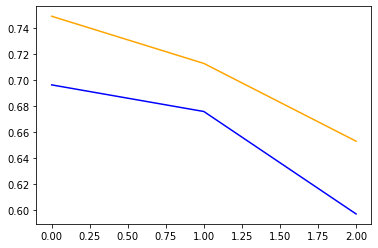

In [97]:
plt.plot(range(len(in_sim)), in_sim, color="blue")
plt.plot(range(len(out_sim)), out_sim, color="orange")
plt.show()

In [93]:
NomProbDist = npd(labels=labels, years=yrs, min_count = 10)

In [112]:
NomProbDist

{2006: [0.3103448275862069, 0.4827586206896552, 0.20689655172413793],
 2007: [0.30303030303030304, 0.45454545454545453, 0.24242424242424243],
 2008: [0.38461538461538464, 0.4125874125874126, 0.20279720279720279],
 2009: [0.38666666666666666, 0.32, 0.29333333333333333],
 2010: [0.3681592039800995, 0.46766169154228854, 0.16417910447761194],
 2011: [0.3148148148148148, 0.5185185185185185, 0.16666666666666666],
 2012: [0.3076923076923077, 0.46153846153846156, 0.23076923076923078],
 2013: [0.2694063926940639, 0.5114155251141552, 0.2191780821917808],
 2014: [0.3191489361702128, 0.42021276595744683, 0.26063829787234044],
 2015: [0.35135135135135137, 0.41216216216216217, 0.23648648648648649],
 2016: [0.3317307692307692, 0.4423076923076923, 0.22596153846153846],
 2017: [0.3626373626373626, 0.41208791208791207, 0.22527472527472528],
 2018: [0.3990160538581046, 0.42931123770067325, 0.17167270844122218],
 2019: [0.4419161676646707, 0.38562874251497004, 0.1724550898203593],
 2020: [0.42225293711126

In [113]:
proportions =zip(*[tuple(pair) for pair in NomProbDist.values()])

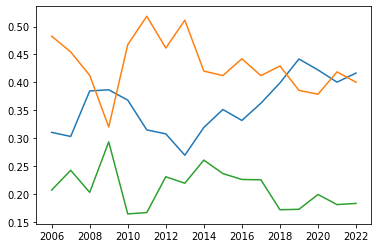

In [114]:
for lab_proportion in proportions:
    plt.plot(NomProbDist.keys(), lab_proportion)
# plt.legend(list(range(len(NomProbDist))))
plt.show()

In [9]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html
def aff_prop(data, random_seed = 10):
    start_time = time.time()
    print("N =", len(data))
    model = AffinityPropagation(random_state=random_seed).fit(data)
    labels = model.labels_
    delta = time.time() - start_time
    print(int(delta / 60), int(delta % 60))
    print("No. labels:", len(set(labels)))
    print("Silhoette score:", silhouette_score(data, model.labels_))
    for lab, cnt in Counter(labels).items():
        print(lab, cnt)
    return labels

In [10]:
def cluster_representation(clusters, contexts, top_k = 50, stop_words = None):
    
    assert len(clusters) == len(contexts)
    
    df = pd.DataFrame({"Cluster": clusters, "Context": contexts})
    docs_per_class = df.groupby(["Cluster"], as_index=False).agg({"Context": " ".join})
    count_vectorizer = CountVectorizer(stop_words = stop_words)
    count = count_vectorizer.fit_transform(docs_per_class.Context)
    words = count_vectorizer.get_feature_names_out()
    ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(df)).toarray()
    #words_per_class = {newsgroups.target_names[label]: [words[index] for index in ctfidf[label].argsort()[-10:]] for label in docs_per_class.Class}
    words_per_class = {label: [words[index] for index in ctfidf[label].argsort()[-top_k:]] for label in docs_per_class.Cluster}
    
    return words_per_class

In [11]:
def visualize(data, labels):
    XR = dimensionality_reduction(data, k=2)
    A = []
    B = []
    for x in XR:
        A.append(x[0])
        B.append(x[-1])
    plt.scatter(A, B, c=labels, alpha = 0.6, s=10)

In [13]:
def mnd(labels, years, min_count=10): # MultiNominal (frequency) distribution
    
    label_counts = {year: {label: 0 for label in set(labels)} for year in set(years)}
    
    for year, label in zip(years, labels):
        label_counts[year][label] += 1    

    fdv = {year: [] for year in years} # Frequency Distribtion Vectors
    
    for year in label_counts.keys():
        for label in sorted(label_counts[year].keys()):
            count = label_counts[year][label]
            fdv[year].append(count)
    
    return fdv


In [14]:
# https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
# https://www.statology.org/kl-divergence-python/
# https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810
def kl(p, q):
    return sum(rel_entr(q, p))

In [15]:
def get_transitions(start_year, end_year):
    transitions = [(yi, yi+1) for yi in range(start_year, end_year)]
    return transitions

In [16]:
def get_jsd(pdv_data, transitions = get_transitions(2000, 2022)):
    
    jsd = dict()
    Yrs = []
    Chg = []
    
    for yi, yj in transitions:
        if yi not in pdv_data:
            continue
        if yj not in pdv_data:
            continue
        p = pdv_data[yi]
        q = pdv_data[yj]
        change = jensenshannon(p, q)
        
        Yrs.append(yj)
        Chg.append(change)
        jsd[f"{yi}_{yj}"] = change
        
    return jsd, Yrs, Chg

In [17]:
xt = expected_freq([[0,1], [1,2]])

In [18]:
xt.size

4

In [19]:
def get_chi2(fdv_data, transitions = get_transitions(2000, 2022)):
    
    chi_squared_results = dict()
    dofs = dict()
    Ps   = dict()
    
    for yi, yj in transitions:
        t_name = f"{yi}_{yj}"
        
        if yi not in fdv_data:
            continue
        if yj not in fdv_data:
            continue
            
        row1 = fdv_data[yi]
        row2 = fdv_data[yj]
        
        table = [row1, row2]

        x_tab = expected_freq(table)
        
        skip = False
        for r in x_tab:
            for l in r:
                if l < 5:
                    skip = True
        
        if skip: #
            chi_squared_results[t_name] = None
            dofs[t_name] = None
            Ps[t_name] = None
            
        
        else:
            #print("X2 here ...")
            test_res = chi2_contingency(table)
            
            chi_squared_results[t_name] = test_res.statistic
            dofs[t_name] = test_res.dof
            Ps[t_name] = test_res.pvalue
        
    return chi_squared_results, dofs, Ps
    
    

In [20]:
def populator(clustering, years):
    
    results = {}
    
    # Nominal probability distribution
    npvs = npd(clustering, years)
    results["npd"] = npvs
    
    # JSD
    jsd, Y, C = get_jsd(npvs, transitions = get_transitions(2000, 2022))
    
    results["jsd"] = jsd
    results["years"] = Y
    results["changes"] = C
    
    # MultiNominal (frequency) distribution
    fdvs = mnd(clustering, years)
    results["mnd"] = fdvs    

    # Chi-squared
    X2, dofs, ps = get_chi2(fdvs, transitions = get_transitions(2000, 2022))

    results["chi2"] = X2
    results["dofs"] = dofs
    results["p(chi2)"] = ps
    
    return results

In [21]:
def multi_clust(file, v_root):
    
    multi_results = {}
    
    years, X = get_vec(file)
    print("Length:", len(years))
    if len(years) < 3:
        return None # Obs!
    
    contexts = get_ctx(rename_for_ctx(file, v_root))
    
    Xr, vx_log = dimensionality_reduction(X, k=50)
    
    if len(years) < 5000:
        large = True
    else:
        large = False
    
    print()
    print("KMS")
    if large:
        kms, log = clustering(X, method = "kmeans-batch")
    else:
        kms, log = clustering(X)
    multi_results["kms"] = populator(kms, years)
    multi_results["kms"]["cluster_counts"] = Counter(kms)
    multi_results["kms"]["words_per_class"] = cluster_representation(kms, contexts, stop_words=STOP_WORDS)
    multi_results["kms"]["log"] = log
    multi_results["kms"]["vx_log"] = None
    
    print()
    print("KM5")
    if large:
        km5, log = clustering(X, method = "kmeans-batch", k = 5, silohouette = False)
    else:
        km5, log = clustering(X, k = 5, silohouette = False)
    multi_results["km5"] = populator(km5, years)
    multi_results["km5"]["cluster_counts"] = Counter(km5)
    multi_results["km5"]["words_per_class"] = cluster_representation(km5, contexts, stop_words=STOP_WORDS)
    multi_results["km5"]["log"] = log
    multi_results["km5"]["vx_log"] = None
    
    print()
    print("KM15")
    if large:
        km15, log = clustering(X, method = "kmeans-batch", k = 15, silohouette = False)
    else:    
        km15, log = clustering(X, k = 15, silohouette = False)
    multi_results["km15"] = populator(km15, years)
    multi_results["km15"]["cluster_counts"] = Counter(km15)
    multi_results["km15"]["words_per_class"] = cluster_representation(km15, contexts, stop_words=STOP_WORDS)
    multi_results["km15"]["log"] = log
    multi_results["km15"]["vx_log"] = None    
    
    print()
    if len(years) < 12000:
        print("ACS")
        acs, log = clustering(X, method = "agglomerative_cosine")
        multi_results["acs"] = populator(acs, years)
        multi_results["acs"]["cluster_counts"] = Counter(acs)
        multi_results["acs"]["words_per_class"] = cluster_representation(acs, contexts, stop_words=STOP_WORDS)
        multi_results["acs"]["log"] = log
        multi_results["acs"]["vx_log"] = None
    else:
        print("Skipped ACS")
    
    print()
    print("KMS-R50")
    if large:
        kmsr50, log = clustering(Xr, method = "kmeans-batch")
    else:    
        kmsr50, log = clustering(Xr)
    multi_results["kmsr50"] = populator(kmsr50, years)
    multi_results["kmsr50"]["cluster_counts"] = Counter(kmsr50)
    multi_results["kmsr50"]["words_per_class"] = cluster_representation(kmsr50, contexts, stop_words=STOP_WORDS)
    multi_results["kmsr50"]["log"] = log
    multi_results["kmsr50"]["vx_log"] = vx_log
    
    print()
    if len(years) < 12000:
        print("ACS-R50")
        acsr50, log = clustering(Xr, method = "agglomerative_cosine")
        multi_results["acsr50"] = populator(acsr50, years)
        multi_results["acsr50"]["cluster_counts"] = Counter(acsr50)
        multi_results["acsr50"]["words_per_class"] = cluster_representation(acsr50, contexts, stop_words=STOP_WORDS)
        multi_results["acsr50"]["log"] = log    
        multi_results["acsr50"]["vx_log"] = vx_log
    else:
        print("Skipped ACS-R50")
    
    #afp    = aff_prop(X)
    
    return multi_results

In [22]:
def viscor(data):
    Xs = []
    Ys = []
    
    for method in data.keys():
        print()
        print(method)
        X = data[method]["years"]
        Y = data[method]["changes"]
        Ys.append(Y)
        #print(X, Y)
        plt.plot(X, Y)
        plt.show()
    
    #print(Ys)
    corr, pval = spearmanr(Ys, axis=1)
    print(pd.DataFrame(corr, columns = data.keys(), index = data.keys()))    

In [23]:
def multi_term(
    directory, 
    v_root  = "/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/", 
    stop = None
):
    
    big_r = dict()
    
    directory = Path("Directory:", directory)
    print(directory)
    
    files = sorted(os.listdir(directory))
    if stop != None:
        files = files[:stop]
    
    for file in files:
        name = file.replace(".txt", "")
        print()
        print(f"--- {name} ---")
        results = multi_clust(directory/file, v_root)
        big_r[name] = results
        
    return big_r

In [24]:
#IN_DIR   = "/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/"
#IN_DIR   = "/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sentence-bert-swedish-cased/"
IN_DIR   = "/home/max/Corpora/familjeliv-smh-time/yearly/contexts_per_term/vectors/sentence-bert-swedish-cased/"

#V_DIR    = "/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/"
V_DIR    = "/home/max/Corpora/familjeliv-smh-time/yearly/contexts_per_term/vectors/"

#FILE_OUT = "/home/max/Results/fb_pol-yearly-bert/sts_fbmodel/cluster_data.json"
#FILE_OUT  = "/home/max/Results/fb_pol-yearly-bert/sentence-bert-swedish-cased/cluster_data.json"
FILE_OUT  = "/home/max/Results/fm_smh-yearly-bert/sentence-bert-swedish-cased/cluster_data.json"

In [25]:
my_results = multi_term(
    directory = IN_DIR,
    v_root    = V_DIR,
    stop      = None
)
with open(FILE_OUT, "w") as f:
    f.write(json.dumps(my_results, indent = 4))

/home/max/Corpora/familjeliv-smh-time/yearly/contexts_per_term/vectors/sentence-bert-swedish-cased

--- A1_globalistisk ---
Length: 32
For reduction to n_components = 50, 100 % explained

KMS
The average silhouette_score for k = 2 is: 0.08344646626281896.
The average silhouette_score for k = 3 is: 0.1194185030560388.
The average silhouette_score for k = 4 is: 0.1081502335643535.
The average silhouette_score for k = 5 is: 0.09353027041519744.
The average silhouette_score for k = 6 is: 0.1265472308759125.
The average silhouette_score for k = 7 is: 0.11770587619477704.
The average silhouette_score for k = 8 is: 0.13696535233025076.
The average silhouette_score for k = 9 is: 0.1541219146716652.
The average silhouette_score for k = 10 is: 0.18509999160233354.
Best score for k = 10 (0.18510).

KM5

KM15

ACS
The average silhouette_score for k = 2 is: 0.07659627139604983.
The average silhouette_score for k = 3 is: 0.11159994227849576.
The average silhouette_score for k = 4 is: 0.1192984765822

The average silhouette_score for k = 8 is: 0.037476768788034.
The average silhouette_score for k = 9 is: 0.03911256838779485.
The average silhouette_score for k = 10 is: 0.0382853395655222.
Best score for k = 2 (0.06421).

KM5

KM15

ACS
The average silhouette_score for k = 2 is: 0.06422486388443506.
The average silhouette_score for k = 3 is: 0.0660853674270699.
The average silhouette_score for k = 4 is: 0.0628474044348579.
The average silhouette_score for k = 5 is: 0.05734836805196333.
The average silhouette_score for k = 6 is: 0.05920828959216985.
The average silhouette_score for k = 7 is: 0.060330996271683424.
The average silhouette_score for k = 8 is: 0.061778683467648546.
The average silhouette_score for k = 9 is: 0.06360037635741865.
The average silhouette_score for k = 10 is: 0.06241985816133344.
Best score for k = 3 (0.06609).

KMS-R50
The average silhouette_score for k = 2 is: 0.03539319967412285.
The average silhouette_score for k = 3 is: 0.053817951137732536.
The average sil

<ipython-input-8-755cf98fbc45>:61: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  model = KMeans(n_clusters = k, random_state = random_seed, n_init = initialization).fit(data)


The average silhouette_score for k = 4 is: 0.24036407743400037.
The average silhouette_score for k = 5 is: 0.3059292500720205.
The average silhouette_score for k = 6 is: 0.32189466249869575.
The average silhouette_score for k = 7 is: 0.4766616846294077.
The average silhouette_score for k = 8 is: 0.6585544957108983.
The average silhouette_score for k = 9 is: 0.6368630334029595.
The average silhouette_score for k = 10 is: 0.6287568482405318.
Best score for k = 8 (0.65855).

KMS-R50
The average silhouette_score for k = 2 is: 0.22054969356864948.
The average silhouette_score for k = 3 is: 0.31045022439378733.
The average silhouette_score for k = 4 is: 0.4285475209693083.
The average silhouette_score for k = 5 is: 0.6377466773749425.
The average silhouette_score for k = 6 is: 0.5860913933160415.
The average silhouette_score for k = 7 is: 0.5928358962621876.
The average silhouette_score for k = 8 is: 0.6585544930107395.
The average silhouette_score for k = 9 is: 0.6103047483438563.
The avera


KMS-R50
The average silhouette_score for k = 2 is: 0.07047755483083835.
The average silhouette_score for k = 3 is: 0.09520246257586754.
The average silhouette_score for k = 4 is: 0.10438900693299276.
The average silhouette_score for k = 5 is: 0.10983971924999736.
The average silhouette_score for k = 6 is: 0.081518876652309.
The average silhouette_score for k = 7 is: 0.08277859994742759.
The average silhouette_score for k = 8 is: 0.09789208433657301.
The average silhouette_score for k = 9 is: 0.0892493970097462.
The average silhouette_score for k = 10 is: 0.09059197994324125.
Best score for k = 5 (0.10984).

ACS-R50
The average silhouette_score for k = 2 is: 0.05537065672093954.
The average silhouette_score for k = 3 is: 0.06276367598119344.
The average silhouette_score for k = 4 is: 0.06697345292985503.
The average silhouette_score for k = 5 is: 0.07025224765036907.
The average silhouette_score for k = 6 is: 0.06460894366073132.
The average silhouette_score for k = 7 is: 0.06926797499

In [26]:
#my_results

In [27]:
#file = Path("/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/N1_förortsgäng.txt")
#file = Path("/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/A1_globalistisk.txt")
#file = Path("/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/N1_globalist.txt")
#file = Path("/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/N1_återvandring.txt")

In [28]:
#mc = multi_clust(Path("/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/N1_förortsgäng.txt"))

In [29]:
#viscor(mc)

In [30]:
#mc["kms"].keys()

In [31]:
#mc["kms"]["cluster_counts"]

In [32]:
#mc["kms"]["words_per_class"]

In [33]:
#mc

In [34]:
#multi_clust(Path("/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/N1_återvandring.txt"))

In [35]:
#multi_clust(Path("/home/max/Corpora/flashback-pol-time/yearly/contexts_per_term/vectors/sts_fbmodel/V1_kulturberika.txt"))

In [36]:
#model = clustering(X)
#model = clustering(X, method = "agglomerative_cosine")
#model = kmeans(X, k_range = (2, 12))
#best_model = kmeans(Xr, k = 10, silohouette=False)
#model = aff_prop(Xr)

In [37]:
#visualize(X, model)